#### 1. Import the Relevent Packages

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchsummary import summary
import os
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2. Prepare the Dataset

In [51]:
class MyDataset(Dataset):
    
    def __init__(self, root, transform_status=True):
        
        self.root = root
        self.images_paths = [glob(f'{root}/{folder}/*.jpg') for folder in os.listdir(f"{root}")] 

        import itertools
        self.images_paths = list(itertools.chain.from_iterable(self.images_paths))

        import random
        random.shuffle(self.images_paths)

        self.classes_names = {class_name:label for label, class_name in enumerate(os.listdir(f"{root}"))}
        self.labels = [self.classes_names[os.path.basename(os.path.dirname(path))] for path in self.images_paths]
        self.transform_status = transform_status
        self.transform = transforms.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
    
    def __len__(self):
        return len(self.images_paths)   
        
    def __getitem__(self, index):
        image_path = self.images_paths[index]
        image = cv2.imread(image_path)[:,:,::-1]
        image = cv2.resize(image, (64,64))
        image = torch.tensor(image/255).permute(2,0,1)
        if self.transform_status: image = self.transform(image)
        label = self.labels[index]
        
        return image.float().to(device), torch.tensor([label]).float().to(device)
    
    

In [52]:
data =  MyDataset("dataset_rgb/train", transform_status=False)

In [53]:
data.classes_names

{'River': 0,
 'HerbaceousVegetation': 1,
 'Residential': 2,
 'Highway': 3,
 'SeaLake': 4,
 'AnnualCrop': 5,
 'PermanentCrop': 6,
 'Forest': 7,
 'Industrial': 8,
 'Pasture': 9}

In [54]:
import random
image, label = data[random.randint(0, len(data))]

Image Size: 64 x 64 x 3
Label: tensor([3.], device='cuda:0')
Highway


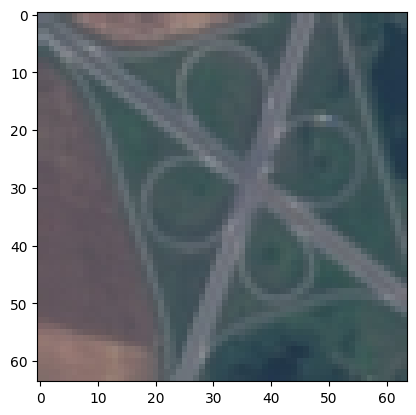

In [55]:
print(f"Image Size: {image.shape[2]} x {image.shape[1]} x {image.shape[0]}")
print(f"Label: {label}")
print([key  for key, value in data.classes_names.items() if value == label][0])
plt.imshow(image.permute(1,2,0).cpu().numpy())
plt.show()

In [56]:
train_dataset = MyDataset("dataset_rgb/train", transform_status=True)
test_dataset = MyDataset("dataset_rgb/test", transform_status=True)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

#### 3. Build the Model

In [57]:
def build_model():
    vgg19 = models.vgg19(pretrained=True)
    for param in vgg19.parameters():
        param.requires_grad = False
    vgg19.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    vgg19.classifier = nn.Sequential(   nn.Flatten(),
                                        nn.Linear(512, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(128, 10))
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(vgg19.parameters(), lr=1e-3)

    return vgg19.to(device), loss_function, optimizer

In [58]:
model , loss_function, optimizer = build_model()